Author: Shan Qu, Delft University of Technology

First created: 4 April 2021

Product: data preprocessing + a basic risk modeling test (without feature selection, using only default hyperparameters), based on the following algorithms:
*   Logistic regression
*   CART tree
*   Random forest
*   XGBoost
*   SVM
*   Neural network




In [168]:
!pip install category_encoders
!pip install xgboost

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

pd.set_option('display.max_columns', 20)
seed = 143

In [169]:
df_data = pd.read_csv('df_data_clean.csv')
print(df_data.info())
N_data = len(df_data)

# drop the unnamed ID column
df_data.drop('Unnamed: 0', axis=1, inplace=True)

df_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   object
 4   Housing           1000 non-null   object
 5   Saving accounts   1000 non-null   object
 6   Checking account  1000 non-null   object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(4), object(7)
memory usage: 86.1+ KB
None


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,skilled,own,Other,little,1169,6,radio/TV,good
1,22,female,skilled,own,little,moderate,5951,48,radio/TV,bad
2,49,male,unskilled and resident,own,little,Other,2096,12,education,good
3,45,male,skilled,free,little,little,7882,42,furniture/equipment,good
4,53,male,skilled,free,little,little,4870,24,car,bad
5,35,male,unskilled and resident,free,Other,Other,9055,36,education,good
6,53,male,skilled,own,quite rich,Other,2835,24,furniture/equipment,good
7,35,male,highly skilled,rent,little,moderate,6948,36,car,good
8,61,male,unskilled and resident,own,rich,Other,3059,12,radio/TV,good
9,28,male,highly skilled,own,little,moderate,5234,30,car,bad


In [170]:
df_X = df_data.iloc[:, 0:-1]
df_y = df_data.iloc[:, -1].replace({'good': 0, 'bad': 1})
df_y

0      0
1      1
2      0
3      0
4      1
      ..
995    0
996    0
997    0
998    1
999    0
Name: Risk, Length: 1000, dtype: int64

### 2.1 Encoding the categorical data

**Categorical Variable Encoders:**
* OneHotEncoder: performs one hot encoding, optional: of popular categories
* CountFrequencyEncoder: replaces categories by observation count or percentage
* OrdinalEncoder: replaces categories by numbers arbitrarily or ordered by target
* MeanEncoder: replaces categories by the target mean
* WoEEncoder: replaces categories by the weight of evidence
* PRatioEncoder: replaces categories by a ratio of probabilities
* DecisionTreeEncoder: replaces categories by predictions of a decision tree
* RareLabelEncoder: groups infrequent categories


**Overview:**  https://readthedocs.org/projects/feature-engine/downloads/pdf/latest/


In [171]:
#Use ordinal encoding for ordinal categorical variable:
# 'Job', 'Saving accounts', 'Checking account'
#df_X['Job'] = df_X['Job'].replace(
#    {'unskilled and non-resident': 0, 'unskilled and resident': 1
#     , 'skilled': 2, 'highly skilled': 3})

#df_X['Saving accounts'] = df_X['Saving accounts'].replace(
#    {'Other': 0, 'little': 1, 'moderate': 2, 'quite rich': 3, 'rich': 4})

#df_X[['Job', 'Saving accounts']] = ce.backward_difference.BackwardDifferenceEncoder().fit_transform(df_X[['Job', 'Saving accounts']], y=df_y)
# 'Other' has quite a big proportion, check it into 'moderate'
#df_X['Checking account'] = df_X['Checking account'].replace(
#    {'Other': 2, 'little': 1, 'moderate': 2, 'rich': 3})

df_X.describe()
# Create two data sets for quantitative and qualitative data
df_X_mum = df_X.select_dtypes(exclude=['object'])
df_X_cat = df_X.select_dtypes(include=['object'])
print(df_X_cat.head())


df_X_cat_new = ce.OneHotEncoder().fit_transform(df_X_cat, y=df_y)
#df_X_cat_new = ce.WOEEncoder().fit_transform(df_X_cat, y=df_y)
#df_X_cat_new = ce.cat_boost.CatBoostEncoder().fit_transform(df_X_cat, y=df_y)
#df_X_cat_new = ce.sum_coding.SumEncoder().fit_transform(df_X_cat, y=df_y)

df_X_prep = pd.concat([df_X_mum, df_X_cat_new], axis=1)
print(df_X_prep.columns)
df_X_prep.head()

      Sex                     Job Housing Saving accounts Checking account  \
0    male                 skilled     own           Other           little   
1  female                 skilled     own          little         moderate   
2    male  unskilled and resident     own          little            Other   
3    male                 skilled    free          little           little   
4    male                 skilled    free          little           little   

               Purpose  
0             radio/TV  
1             radio/TV  
2            education  
3  furniture/equipment  
4                  car  
Index(['Age', 'Credit amount', 'Duration', 'intercept', 'Sex_0', 'Job_0',
       'Job_1', 'Job_2', 'Housing_0', 'Housing_1', 'Saving accounts_0',
       'Saving accounts_1', 'Saving accounts_2', 'Saving accounts_3',
       'Checking account_0', 'Checking account_1', 'Checking account_2',
       'Purpose_0', 'Purpose_1', 'Purpose_2', 'Purpose_3', 'Purpose_4',
       'Purpose_5', 

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Age,Credit amount,Duration,intercept,Sex_0,Job_0,Job_1,Job_2,Housing_0,Housing_1,...,Checking account_0,Checking account_1,Checking account_2,Purpose_0,Purpose_1,Purpose_2,Purpose_3,Purpose_4,Purpose_5,Purpose_6
0,67,1169,6,1,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22,5951,48,1,-1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,49,2096,12,1,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,45,7882,42,1,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,53,4870,24,1,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### 2.2 Scale the data and check  the correlation map and feature importance 

In [172]:
df_X_prep[df_X_prep.columns] = MinMaxScaler().fit_transform(df_X_prep[df_X_prep.columns])
df_X_prep.head()

,Age,Credit amount,Duration,intercept,Sex_0,Job_0,Job_1,Job_2,Housing_0,Housing_1,...,Checking account_0,Checking account_1,Checking account_2,Purpose_0,Purpose_1,Purpose_2,Purpose_3,Purpose_4,Purpose_5,Purpose_6
0,0.857143,0.050567,0.029412,0.0,1.0,1.0,0.5,0.5,1.0,0.5,...,1.0,0.5,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5
1,0.053571,0.313690,0.647059,0.0,0.0,1.0,0.5,0.5,1.0,0.5,...,0.5,1.0,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5
2,0.535714,0.101574,0.117647,0.0,1.0,0.5,1.0,0.5,1.0,0.5,...,0.5,0.5,1.0,0.5,1.0,0.5,0.5,0.5,0.5,0.5
3,0.464286,0.419941,0.558824,0.0,1.0,1.0,0.5,0.5,0.5,1.0,...,1.0,0.5,0.5,0.5,0.5,1.0,0.5,0.5,0.5,0.5
4,0.607143,0.254209,0.294118,0.0,1.0,1.0,0.5,0.5,0.5,1.0,...,1.0,0.5,0.5,0.5,0.5,0.5,1.0,0.5,0.5,0.5


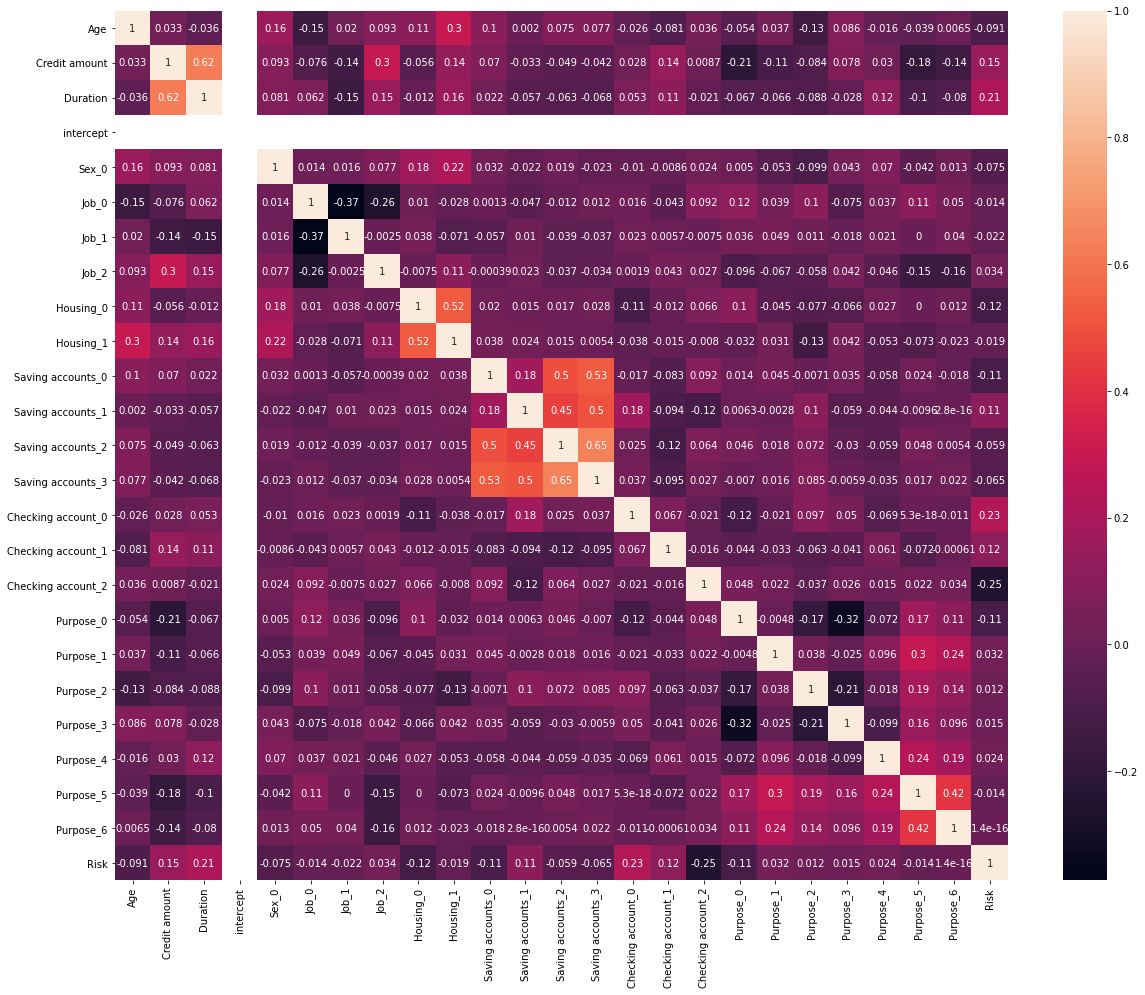

In [173]:
df_X_y = pd.concat([df_X_prep.reset_index(drop = True), df_y.reset_index(drop = True)], axis = 1)
plt.figure(figsize=(20,16))
sns.heatmap(df_X_y.astype(float).corr(), annot=True)
plt.show()

{'Checking account_2': 25, 'Duration': 106, 'Credit amount': 202, 'Saving accounts_1': 7, 'Age': 87, 'Purpose_4': 16, 'Sex_0': 18, 'Saving accounts_0': 25, 'Purpose_1': 15, 'Checking account_0': 20, 'Job_2': 24, 'Checking account_1': 9, 'Job_0': 6, 'Housing_0': 13, 'Purpose_0': 15, 'Purpose_3': 5, 'Saving accounts_3': 16, 'Purpose_2': 4, 'Housing_1': 6, 'Job_1': 5, 'Purpose_6': 5}


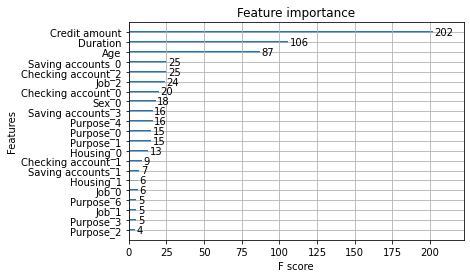

In [174]:
# quick check for the importance of features via XGBoost
clf_gbt = XGBClassifier().fit(df_X_prep,np.ravel(df_y))

# Print the column importances from the model
print(clf_gbt.get_booster().get_score(importance_type = 'weight'))
# Plot the column importance for this model
plot_importance(clf_gbt, importance_type = 'weight')
plt.show()

### 2.3 Divide the data into train and validation data

In [175]:
df_X_train, df_X_val, df_y_train, df_y_val = train_test_split(df_X_prep, df_y, test_size=.2, random_state=seed)

### 2.4 Deal with class imbalance in the data

* Gather more data
* Up-sample minority class
* Down-sample majority class
* Penalize Algorithms
For XGBoost, log-loss is used, therefore, the class imbalance is not a bit problem. However, false negative (default predicted as non-default) has more negative financial impact and this cannot be handled by XGBoost

In [176]:
df_X_y_train = pd.concat([df_X_train.reset_index(drop = True), df_y_train.reset_index(drop = True)], axis = 1)
nondefaults = df_X_y_train[df_X_y_train['Risk'] == 0]
defaults = df_X_y_train[df_X_y_train['Risk'] == 1]
count_nondefault, count_default = df_X_y_train['Risk'].value_counts()

# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)

# Concatenate the undersampled nondefaults with defaults
df_X_y_train = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

df_X_train = df_X_y_train.iloc[:, 0:-1]
df_y_train = df_X_y_train.iloc[:, -1]
print(df_X_train.columns)

        Age  Credit amount  Duration  intercept  Sex_0  Job_0  Job_1  Job_2  \
0  0.089286       0.453230  0.647059        0.0    0.0    1.0    0.5    0.5   
1  0.589286       0.108562  0.294118        0.0    1.0    1.0    0.5    0.5   
2  0.178571       0.170959  0.250000        0.0    0.0    1.0    0.5    0.5   
3  0.196429       0.204083  0.470588        0.0    1.0    0.5    0.5    1.0   
4  0.982143       0.175966  0.014706        0.0    1.0    0.5    1.0    0.5   

   Housing_0  Housing_1  ...  Checking account_0  Checking account_1  \
0        1.0        0.5  ...                 0.5                 1.0   
1        1.0        0.5  ...                 0.5                 0.5   
2        1.0        0.5  ...                 1.0                 0.5   
3        1.0        0.5  ...                 1.0                 0.5   
4        1.0        0.5  ...                 0.5                 0.5   

   Checking account_2  Purpose_0  Purpose_1  Purpose_2  Purpose_3  Purpose_4  \
0           

### 2.5 Write the data out for the next step --- Training with different models

In [179]:
df_X_train.to_csv('df_X_train.csv')
df_X_val.to_csv('df_X_val.csv')
df_y_train.to_csv('df_y_train.csv')
df_y_val.to_csv('df_y_val.csv')

### 2.6 An overview of credit modeling using different models with only default parameters

Training using different algorithms and compare the cross-validation scores, classification report, confusion matrix, AUC(area under curve) scores, and ROC curves
* Logistic_regression
* CART_tree
* Random_forest
* XGBoost
* SVM
* NN

In [177]:
df_training = pd.DataFrame.from_dict({'names': ['Logistic_regression'
    , 'CART_tree', 'Random_forest', 'XGBoost', 'SVM', 'NN']
    , 'models': [LogisticRegression(solver='lbfgs', max_iter=300)
    , DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()
    , SVC(), MLPClassifier()]})

df_training

,names,models
0,Logistic_regression,"LogisticRegression(C=1.0, class_weight=None, d..."
1,CART_tree,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
2,Random_forest,"RandomForestClassifier(bootstrap=True, ccp_alp..."
3,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'..."
4,SVM,"SVC(C=1.0, break_ties=False, cache_size=200, c..."
5,NN,"MLPClassifier(activation='relu', alpha=0.0001,..."


Computing cross-validated metrics for  Logistic_regression
Computing cross-validated metrics for  CART_tree
Computing cross-validated metrics for  Random_forest
Computing cross-validated metrics for  XGBoost
Computing cross-validated metrics for  SVM
Computing cross-validated metrics for  NN


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


                 names                                             models  \
0  Logistic_regression  LogisticRegression(C=1.0, class_weight=None, d...   
1            CART_tree  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
2        Random_forest  RandomForestClassifier(bootstrap=True, ccp_alp...   
3              XGBoost  XGBClassifier(base_score=0.5, booster='gbtree'...   
4                  SVM  SVC(C=1.0, break_ties=False, cache_size=200, c...   
5                   NN  MLPClassifier(activation='relu', alpha=0.0001,...   

                                   cv_score_overview  
0  [0.6190476190476191, 0.6875, 0.730158730158730...  
1  [0.6190476190476191, 0.6875, 0.587301587301587...  
2  [0.5714285714285714, 0.6875, 0.666666666666666...  
3  [0.5714285714285714, 0.765625, 0.6984126984126...  
4  [0.6190476190476191, 0.671875, 0.6984126984126...  
5  [0.5714285714285714, 0.65625, 0.74603174603174...  


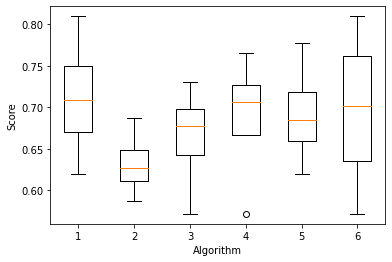

In [178]:
def false_negative_scorer(clf, X, y):
  y_pred = clf.predict(X)
  cm = confusion_matrix(y, y_pred)
  return cm[1, 0]

#scoring_method = 'f1'
scoring_method = 'recall'
#scoring_method = 'roc_auc'

ls_score = []
for index in np.arange(len(df_training)):
  print("Computing cross-validated metrics for ", df_training.iloc[index, 0])
  #print(df_training.iloc[index, 1])
  score = cross_val_score(df_training.iloc[index, 1], df_X_train, np.ravel(df_y_train), cv=4, scoring=scoring_method)
  ls_score.append(score)

df_training['cv_score_overview'] = ls_score
print(df_training)

plt.boxplot(df_training['cv_score_overview'])
plt.xlabel('Algorithm')
plt.ylabel('Score')
plt.show()